## Load Data

In [2]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

NUM_CLASSES = 10
INPUT_SIZE = 784

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## Data Visualization

0


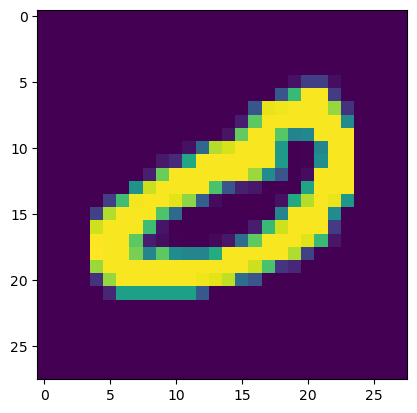

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

random_index = np.random.randint(0, len(x_train))

print(y_train[random_index])
plt.imshow(x_train[random_index]);

(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

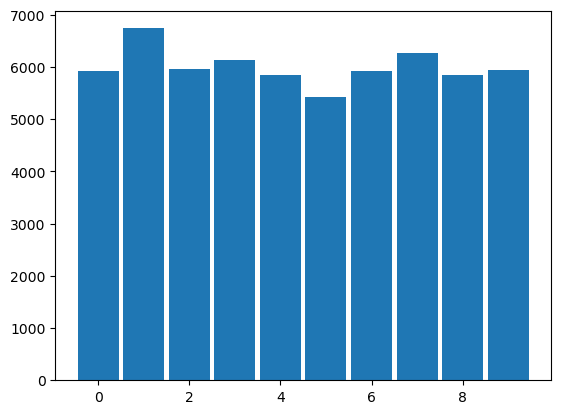

In [4]:
plt.hist(y_train, bins=range(11), align='left', rwidth=0.9)

## Normalization

In [5]:
x_train = x_train / 127.5 - 1
x_test = x_test / 127.5 - 1

In [6]:
x_train = x_train.reshape(x_train.shape[0], INPUT_SIZE)
x_test = x_test.reshape(x_test.shape[0], INPUT_SIZE)

In [7]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## TensorFlow Model

In [8]:
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam



model_tf_1 = Sequential()
model_tf_1.add(Dense(
        units=128,
        activation='relu',
        kernel_initializer='he_normal'
))
model_tf_1.add(Dense(
        units=64,
        activation='relu',
        kernel_initializer='he_normal'
))
model_tf_1.add(Dense(
        units=NUM_CLASSES,
        activation='softmax',
        kernel_initializer='he_normal'
))

model_tf_1.compile(
        optimizer=Adam(learning_rate=0.0002),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
)

model_tf_1.fit(
        x=x_train,
        y=y_train,
        epochs=5,
        validation_data=(x_test, y_test),
        batch_size=16
)


Epoch 1/5
3750/3750 [==============================] - 72s 19ms/step - loss: 0.3580 - accuracy: 0.8929 - val_loss: 0.1921 - val_accuracy: 0.9419
Epoch 2/5
3750/3750 [==============================] - 59s 16ms/step - loss: 0.1744 - accuracy: 0.9477 - val_loss: 0.1388 - val_accuracy: 0.9604
Epoch 3/5
3750/3750 [==============================] - 58s 16ms/step - loss: 0.1302 - accuracy: 0.9607 - val_loss: 0.1267 - val_accuracy: 0.9618
Epoch 4/5
3750/3750 [==============================] - 72s 19ms/step - loss: 0.1053 - accuracy: 0.9679 - val_loss: 0.1193 - val_accuracy: 0.9639
Epoch 5/5
3750/3750 [==============================] - 68s 18ms/step - loss: 0.0888 - accuracy: 0.9734 - val_loss: 0.0952 - val_accuracy: 0.9722


## PyTorch Model

In [9]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 3. Convert data to PyTorch tensors using torch.from_numpy()
x_train_torch = torch.from_numpy(x_train).float()
x_test_torch = torch.from_numpy(x_test).float()
y_train_torch = torch.from_numpy(y_train).long()
y_test_torch = torch.from_numpy(y_test).long()

class PyTorchModel_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(INPUT_SIZE, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, NUM_CLASSES)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.layer4(x)  # No activation, CrossEntropyLoss will take care of it
        return x

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        m.bias.data.fill_(0)

model_torch_1 = PyTorchModel_1()
model_torch_1.apply(init_weights)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_torch_1.parameters(), lr=0.0002)


train_dataset = TensorDataset(x_train_torch, y_train_torch)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)

for epoch in range(3):  # Number of epochs
    model_torch_1.train()  # Set the model to training mode
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad() # Clear the gradients
        outputs = model_torch_1(inputs) # Forward pass
        loss = loss_func(outputs, labels) # Calculate the loss
        loss.backward() # Calculate the gradients (backpropagation)
        optimizer.step() # Update the weights
        running_loss += loss.item() # Accumulate the loss

    print(f'Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}')


    # Validation phase
    model_torch_1.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0

    with torch.no_grad():  # Inference without gradient calculationS
        total += y_test_torch.size(0)
        outputs = model_torch_1(x_test_torch)
        
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == y_test_torch).sum().item()

    print(f'Epoch {epoch + 1}, Validation Accuracy: {100 * correct / total}%')

Epoch 1, Training Loss: 0.37334558001843593
Epoch 1, Validation Accuracy: 93.57%
Epoch 2, Training Loss: 0.18544389264471828
Epoch 2, Validation Accuracy: 95.33%
Epoch 3, Training Loss: 0.14057833725974583
Epoch 3, Validation Accuracy: 95.7%
